In [1]:
# 라이브러리 호출 및 저장
import bok_da as bd
import numpy as np
import pandas as pd
import scipy.stats as sp
import matplotlib.pyplot as plt
import seaborn as sns

#### 본 매뉴얼은 시계열 변수의 AR(p) 모형 OLS 추정에 대해 다룬다. 

## 1. 데이터 불러오기
- 작성자: 고려대학교 경제학과 강규호 교수, 디지털신기술팀 이창훈 과장

데이터는 한국의 전기대비 실질 GDP 성장률, CD91일 금리, 인플레이션율 소비자 가격 지수 (Consumer Price Index, CPI), CD91일 금리로 1999년 4분기부터 2023년 4분끼지의 분기별 자료이다. 해당 데이터는 ECOS (https://ecos.bok.or.kr/#/)에서 다운로드 받았으며 컴퓨터에 "python_data.xlsx"라는 이름의 엑셀파일의 "KORmacro"라는 시트에 저장되어 있다. 이때, 인플레이션율의 경우 소비자 가격 지수 (Consumer Price Index, CPI)의 전년동기대비 치분 (YoY)을 통해 미리 변환한 것이다.

`data` 폴더에서 `python_data.xlsx`를 불러온 후 파이썬 표준 자료형인 `pandas.DataFrame`으로 전처리를 수행한다. `DataFrame`은 테이블 형태의 데이터의 행(날짜)과 열(변수명) 정보를 가지고 있어, 행렬이나 벡터형태로 분석하는 것보다 유용하다. `df`라는 이름으로 할당하는 것이 일반적이다. 데이터프레임에 익숙하지 않은 경우 아래 셀의 코드를 줄별로 여러 셀로 나누어 실행해보는 것을 추천한다. 원천기관에서 raw 데이터를 불러오고 전처리하는 과정이 복잡해 보일 수 있지만, 한번 해두면 크게 코드를 수정할 필요없이 새로운 데이터에 대해서도 분석 가능한 형태로 전처리 할 수 있기 때문에 장기적으로 효율적인 방법이다.

In [2]:
df = pd.read_excel('data/python_data.xlsx', sheet_name='KORmacro') # 데이터 엑셀파일 불러오기
df = df.set_index('date') # date 명의 열을 인덱스로 지정한다.
df.index.name = None # 인덱스 이름 date를 제거한다.
df.index = df.index.str.replace('/', '-') # 2000/03 형식을 pandas가 날짜로 인식하도록 2000-3형식으로 변환한다.
df.index = pd.to_datetime(df.index) + pd.offsets.QuarterEnd(0) # 인덱스(행)를 날짜로 인식하도록 변환한다.
df.index.freq = pd.offsets.QuarterEnd() # 인덱스의 frequency를 분기말(2000-03-31)로 설정한다.
column_order = ['inf', 'rgdp', 'cd91'] # df의 열 순서를 리스트로 미리 할당
df = df[column_order] # df의 열 순서를 column_order에 맞게 변경
df

,inf,rgdp,cd91
2000-12-31,2.508257,-0.3,6.97
2001-03-31,3.627876,1.2,5.95
2001-06-30,4.919778,1.3,5.78
2001-09-30,4.158456,1.4,4.97
2001-12-31,3.244327,1.8,4.58
...,...,...,...
2022-12-31,5.083054,-0.3,3.91
2023-03-31,4.496285,0.3,3.64
2023-06-30,3.212650,0.6,3.63
2023-09-30,3.079117,0.6,3.74


## 2. 자기회귀모형(Autoregressive of lag p model, AR(p) model)
`bok_da` 라이브러리의 `ar` 함수를 이용해서 AR(p) 모형을 추정할 수 있다. 이때, `ar` 함수는 다음과 같이 구성된다.
> *<p style="font-size:15px">`res = ar(y, lag, h, verbose)`</p>*
> *<p style="font-size:15px">AR(p) 모형에 대한 OLS 추정 결과</p>*
> - **입력**:
    </br>
    y: 추정하고자하는 변수(단변수), T by 1 벡터
    </br>
    lag: 추정하는 모형의 시차
    </br>
    h: 최대 예측 시차(default = None)
    </br>
    verbose: 추정 결과 출력 여부(default = False)
    </br>
> - **출력**:
</br>
    phi_hat: OLS 계수 추정량, lag by 1 벡터
    </br>
    sig2_hat: OLS 분산 추정량, 1 by 1 벡터
    </br>
    f_mat: 동반행렬(Companion Matrix) 형태의 계수 추정량
    </br>
    y0: 추정에 사용된 반응변수, (T-lag) by 1 벡터
    </br>
    y_lag: 추정에 사용된 설명변수, (T-lag) by lag 벡터
    </br>
    y_pred: 예측된 값, h by 1 벡터
    </br>

#### (참고)
시계열에서 단변수 확률과정을 다룰 경우, 설명변수가 $p$시차까지 반응변수의 회귀항들로 구성된 자기회귀모형을 가장 기본적으로 사용한다. 즉, 특정 확률과정 $y_{t}$의 모든 $t$기에 대한 AR(p) 모형은 아래와 같이 구성된다.
$\begin{equation}
    y_{t} = \alpha_{1}y_{t-1} + \cdots + \alpha_{p}y_{t-p} + e_{t}\text{, }e_{t}\sim WN(0,\sigma^{2}) \notag
\end{equation}$
이때, AR(p) 모형은 아래와 같은 특성이 있다.
* 인과-안정성 (causal-stationarity)

    AR(p)모형의 모든 계수항들의 절댓값이 1보다 작다면 해당 확률과정은 인과-안정적 과정 (causal-stationary process)이라고 한다. 한편, 계수항이 1에 가까울수록 확률과정은 이전 기들에 발생한 일이 현재 확률과정에게 중요한 persistent하다고 한다.

* 절편항

    위와 같은 AR(p)모형에는 절편항을 추가할 수 있다. 이때, $v$라는 절편항을 추가하는 것은 $y_{t}$라는 확률과정이 다음과 같은 기댓값을 가지고 있다는 것을 의미한다.
    $\begin{equation}
        \mathbb{E}(y_{t}) = \frac{v}{1-\alpha_{1}-\cdots-\alpha_{p}} \notag
    \end{equation}$
    대안적으로 절편항을 제외하는 대신 사용하는 반응변수의 데이터 $y_{t}$을 평균을 제거하여 사용하는 방법이 있다.

이때, `ar` 함수에는 AR(p) 모형의 절편항을 고려하지 않기 위해 입력되는 `y` 변수에 대해 자동으로 demeaning 과정이 들어가 있다. 따라서, 예측 시 demeaning 과정에서 제거된 mean을 예측값에 더해주도록 코드가 작성되어 있다.

#### (예시)
전년동기대비 인플레이션율에 대한 위와 같은 AR(p)모형을 추정해보자. 이때, 분기별 데이터를 사용하기 때문에 시차는 $p=4$, 예측은 하지 않는다.

`bok_da` 라이브러리 - 시계열분석 패키지(`ts`) - AR모형 서브패키지(`ar`)에서 `ar` 함수를 불러온다.

In [3]:
from bok_da.ts.ar import ar

참고로, AR 모형의 시차 기본값은 1로 설정되어 있다. 시차 인자(lag)를 입력하지 않는 경우, 기본값을 기준으로 추정된다.

In [4]:
y = df['inf']
res = ar(y)

In [5]:
res.get_table()

       Coefficients    S.E.  t-value  p-value
AR_L1        0.8999  0.0463  19.4404      0.0


lag=4를 입력할 경우 AR(4) 모형을 추정한다.

In [6]:
res = ar(y, lag=4)

In [7]:
res.get_table()

       Coefficients    S.E.  t-value  p-value
AR_L1        1.0832  0.1077  10.0581   0.0000
AR_L2       -0.0767  0.1529  -0.5016   0.6159
AR_L3       -0.1446  0.1547  -0.9347   0.3499
AR_L4       -0.0019  0.1064  -0.0178   0.9858


예측을 하고자 하는 경우, h 인자를 통해 수행할 수 있다. 여기서는 h=4로 설정한다.

In [8]:
res = ar(y, lag=4, h=4, verbose=False)

res는 다음의 추정결과를 포함한다.
</br>
`phi_hat`: AR(p) 모형 OLS 계수 추정량
</br>
`omega_hat`: AR(p) 모형 OLS 분산 추정량
</br>
`f_mat`: 동반행렬(Companion Form) 형태의 계수 추정량
</br>
`y0`: 추정에 사용된 반응변수
</br>
`y_lag`: 추정에 사용된 설명변수
</br>
`y_pred`: 예측치

res의 `plot_fitted_resid`와 `plot_forecasts` 메서드를 이용해서 추정결과와 예측결과를 그림으로 나타낼 수 있다.

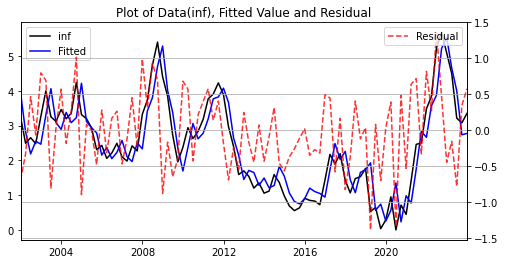

In [9]:
res.plot_fitted_resid(figsize=(8,4))

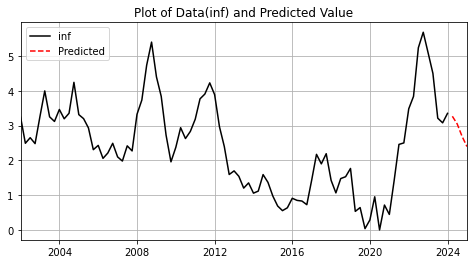

In [10]:
res.plot_forecasts(figsize=(8,4))

추정 결과, 전년동기대비 인플레이션율에 대한 향후 4기 동안의 예측값은 1기 이후 약 3.27\%에서 4기 이후 약 2.40\%까지 점진적으로 감소하는 것으로 나타났다.